# HW 2: Differentially-private Logistic Regression

In this assignment, we will implement a **differentially private** _logistic regression_ model using the **gradient clipping** technique. For this assignment, we will reuse the dataset we used for HW1, the telco customer churning dataset. The goal of this assignment is to understand the gradient clipping and its effect on a learning algorithm's performance.


## Submission instruction
- Due by 11:59pm on **Apr. 21st, 2020**
- Complete this notebook and name it as "*CSCI8960\_HW2\_{your first name}.ipynb*".
- Do **not** use any other 3rd party libraries unless you are asked to do so.
- Do **not** _hardcode_ any data.
- Feel free to modify function prototype (i.e., you can add additional input parameters or remove existing ones based on your needs)
- Feel free to define your own functions if needed.
- Label your graphs.
- All the texts and labels in your graphs should be _legible_.

As before, let's start by importing required libraries.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from scipy.special import expit
import matplotlib.pyplot as plt

%matplotlib inline

The pre-processed telco customer churning dataset can be dowloaded from [here](http://cobweb.cs.uga.edu/~jwlee/datasets/churn_encoded.csv). 

### Q1. (10pts) Load the dataset into a DataFrame and ensure the followings:
- add a dummy column of ones (for bias term)
- $Y \in \{-1, 1\}$
- Split the data into train and test sets 
    - 80% for training and the rest for testing

In [2]:
#---------------------------#
#    Your code goes here    #
#---------------------------#
data = pd.read_csv('churn_encoded.csv', header=0)
data1 = data.dropna()
num_rows = len(data1)
aug_col = pd.DataFrame(np.ones((num_rows, 1)), columns=['aug_col'])
aug_dat = pd.concat([aug_col, data1], axis=1)
aug_dat['Churn'] = aug_dat['Churn'].replace(0,-1)
y = aug_dat['Churn']
X = aug_dat.drop(columns=['Churn'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [3]:
# convert dataframes to numpy arrays for later calculation

X = X.to_numpy()
y = y.to_numpy()
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

Recall the objective function of _logistic regression_ model:
$$ \underset{\mathbf{\beta} \in \mathbb{R}^{p+1}}{\text{minimize}}\, \mathbb{E}[\ell(\beta)] \approx \frac{1}{n}\sum_{i=1}^n \log (1 + \exp(-y_i\mathbf{\beta}^\intercal\mathbf{x}_i))\,, $$
and its gradient is given by
$$ \frac{\partial \ell(\mathbf{\beta})}{\partial \mathbf{\beta}} = \frac{1}{n}\sum_{i=1}^n (\sigma(y_i\mathbf{\beta}^\intercal\mathbf{x}_i)-1)y_i\mathbf{x}_i\,. \qquad\qquad (1) $$

Our gradient descent algorithm performs the following updates.
- initialize starting point $\beta^{(0)}$
- given location $\beta^{(k)}$, updates the solution as follows:
    - $\beta^{(k+1)} = \beta^{(k)} - \eta_k \nabla \ell(\beta^{(k)})\,,$
    
For your convenient, here we provide a code for its objective and gradient. Look at the following code and make sure you understand what it is doing.

In [4]:
def logres_obj(X, y, beta):
    """
    returns the objective value of the logistic regression model
    
    Parameters:
    ------------
    X, y: numpy arrays representing the input dataset
    beta: numpy array correspoinding to the parameter vector
    
    Output:
    -------
    obj: objective value (scalar)
    """
    obj = np.log(1. + np.exp(-y * np.dot(X, beta)))
    loss = np.mean(obj)
    
    return loss

# test code assuming (train_X, train_y) represents your training dataset
beta = np.zeros(X_train.shape[1])
print(logres_obj(X_train, y_train, beta))

beta = np.ones(X_train.shape[1])
print(logres_obj(X_train, y_train, beta))

0.6931471805599454
8.423074043702066


In [5]:
def finite_diff_grad(X, y, beta, h=0.00001):
    """ 
    This function numerically evaluates the gradient of the objective function at beta
    """ 
    p = len(beta)
    grad = np.zeros(p)
    
    for i in range(p):
        e = np.zeros_like(beta)
        e[i] = h
        
        # evalute f(x+h)
        f_beta_h1 = logres_obj(X, y, beta+e)
        
        # evaluate f(x - h)
        f_beta_h2 = logres_obj(X, y, beta-e)
        
        grad[i] = (f_beta_h1 - f_beta_h2) / (2.0 * h)
        
    return grad

In [6]:
def logres_grad(X, y, beta):
    """
    returns the gradient of logistic regression model
    
    Parameters:
    ------------
    X, y: numpy arrays representing the input dataset
    beta: numpy array correspoinding to the parameter vector
    
    Output:
    -------
    grad: 1D numpy array
    """    
    z = (expit(y * np.dot(X, beta)) - 1) * y
    grad = np.mean(z.reshape(-1, 1) * X, axis=0)    
    
    return grad 


# test code
"""
The outputs of two functions, logres_grad() and finite_diff_grad(), should be 
approximately the same.
"""
grad_analytic = logres_grad(X_train, y_train, beta)
grad_numeric = finite_diff_grad(X_train, y_train, beta)

print("L2 distance=", np.linalg.norm(grad_analytic - grad_numeric))

L2 distance= 3.083825505744696e-10


### Q2. (30 pts) Implment the Gradient Clipping
Recall that the sensitivity of gradient computation can be bounded by applying the gradient clipping. Let $C$ be the clipping threshold.
1. For each $\mathbf{x}_i$ in a mini-batch $B$, compute its gradient. Let $\mathbf{g}_i$ denote the gradient.
2. Compute its $L_2$-norm, $\|\mathbf{g}_i\|_2$
3. (gradient clipping): $\overline{\mathbf{g}}_i = \begin{cases}
\frac{C}{\|\mathbf{g}_i\|_2}\mathbf{g}_i & \text{ if } \|\mathbf{g}\|_2 > C \,,\\
\mathbf{g}_i & \text{ otherwise.}
\end{cases}$
4. (noise injection step): $\widetilde{\mathbf{g}} = \sum_{i} \overline{\mathbf{g}}_i + \mathcal{N}(0, C\sigma^2)$  
5. (averaging): $\widetilde{\mathbf{g}} = \widetilde{\mathbf{g}} / |B|$   

Implement `logres_clipped_grad()` function that computes the clipped gradient

In [7]:
def logres_clipped_grad(X, y, beta, C, sigma):
    """
    returns the gradient of logistic regression model
    
    Parameters:
    ------------
    X, y: numpy arrays representing the input dataset
    beta: numpy array correspoinding to the parameter vector
    C: scalar, clipping threshold, the gradient with L2-norm larger than this value will 
       be clipped to this value
    
    Output:
    -------
    noisy_grad: 1D numpy array
    """
    #---------------------------#
    #    Your code goes here    #
    #---------------------------#
    n,p = X.shape
    g_i = logres_grad(X,y,beta)
    g_i_norm = np.linalg.norm(g_i)
    
    if g_i_norm > C:
        # clip gradient
        g_i = g_i * C / g_i_norm
    
    g_tilda = g_i + np.random.normal(0,C * np.power(sigma,2),[p,p])
    noisy_grad = np.average(g_tilda , axis = 0)/n          
    
    return noisy_grad    

### Q3. (30 pts) Implement the stochastic gradient descent (SGD) algorithm.
Using the two functions `logres_obj()` and `logres_clipped_grad()`, implement the stochastic gradient descent algorithm. The core of SGD algorithm is $$\beta^{(k+1)}=\beta^{(k)}-\eta\nabla f(\beta^{(k)}, B)\,,$$
where $B$ denotes a mini-batch. Notice that the gradient evaluated over the examples in the mini-batch, rather than over the whole dataset.
$$ \nabla f(\beta, B) = \frac{1}{|B|}\sum_{i \in B} \nabla \ell(\beta, (\mathbf{x}_i, y_i))$$
The notation $|B|$ denotes the size of mini-batch, i.e., the number of examples in $B$.
1. Initialize the $\beta^{(0)} = (0, 0, \ldots, 0)^\intercal$.
2. While $k\leq \mathtt{max\_iter}$:
    - construct a mini-batch by randomly sampling $\tau=|B|$ indices, i.e., $B\subset \{0, 1, \ldots, n-1\}$, where $n$ is the size of your training dataset.
    - evaluate gradient at $\beta^{(k)}$ using the mini-batch
    - update parameter: $\beta^{(k+1)} = \beta^{(k)} - \eta\nabla f(\beta^{(k)})$

In [8]:
def dp_sgd(X, y, max_iter, C, sigma, batch_size):
    """
    differentially private stochastic gradient descent algorithm
    
    Parameters:
    ----------------
    X, y: input dataset
    max_iter: the number of iterations
    C: clipping threshold
    sigma: scale parameter of noise distribution
    batch_size: the size of mini-batch
                 
    Returns:
    -----------
    sol_path : a list of solutions, the kth entry corresponds to the beta 
               at iteration k
    obj_vals : a list of object values, the kth entry corresponds to the 
               objective value at iteration k               
    """
    sol_path = []
    obj_vals = []
    eta = 0.01       # tune this value to get the best result
    
    n, p = X.shape    
    
    # initialize your parameter vector, beta, here
    beta = np.zeros(p)
    
    for i in range(max_iter):
        
        #---------------------------#
        #    Your code goes here    #
        #---------------------------#
        tau = np.random.randint(low=0,high=n,size=batch_size)
        X_batch = X[tau,:]
        y_batch = y[tau]
        sol_path.append(beta) 
        obj_vals.append(logres_obj(X,y,beta))
        beta = beta - eta * logres_clipped_grad(X_batch,y_batch,beta,C,sigma)
        
        
    return sol_path, obj_vals 

### Q4. (10 pts) Using the following prediction function, report the changes of accuracy and objective values over iterations.
- Fix the clipping threshold $C$ to 4 and test different noise scales $\sigma \in \{0.1, 1, 10, 50, 100\}$
- You can search the value of $\sigma$ that approximately gives you the similar result with non-private algorithm
- Plot the chanage of accuracy and objective values against the number of iterations for both training and test sets.

In [9]:
def predict(X, beta):
    """
    predict the labels of observations in X
    
    Parameters:
    ----------------
    beta: coefficients
    X: 2D numpy array, a set of observations, an example per row
    
    Returns:
    y_hat: predicted labels    
    """
    wx = np.dot(X , beta)
    y_hat = np.ones(X.shape[0])
    y_hat[wx < 0] = -1
    
    return y_hat

In [10]:
def compute_accuracy(testX, testY, sols):
    """
    returns the accuracy of each solution on the given dataset
    
    accuracy = percentage of correctly classified examples
    
    Parameters
    -----------
    testX, testY: input dataset
    sols: a list of parameter vectors
    
    Returns
    --------
    acc: a list of accuracies, each element corresponds to the accuracy of each solution in sols
    """
    acc = []
    
    n_examples = len(testY)
    
    for sol in sols:  
        pred = predict(testX, sol)
        n_correct = n_examples - np.count_nonzero(testY - pred)
        acc.append((n_correct*100.0)/n_examples)
        
    return acc

In [11]:
#---------------------------#
#    Your code goes here    #
#---------------------------#
C = 4 
sigmas = [1, 1.5, 2, 2.5, 3]
col_sc = ['r-','g-','b-','c-','k-']
n_iter = 1000
batch_size = 128

sols = []
objs = []
accs_train = []
accs_test = []

for i in sigmas:
    sol, obj = dp_sgd(X_train, y_train, n_iter, C, i, batch_size)
    sols.append(sol)
    objs.append(obj)
    accs_train.append(compute_accuracy(X_train, y_train, sol))
    accs_test.append(compute_accuracy(X_test, y_test, sol))


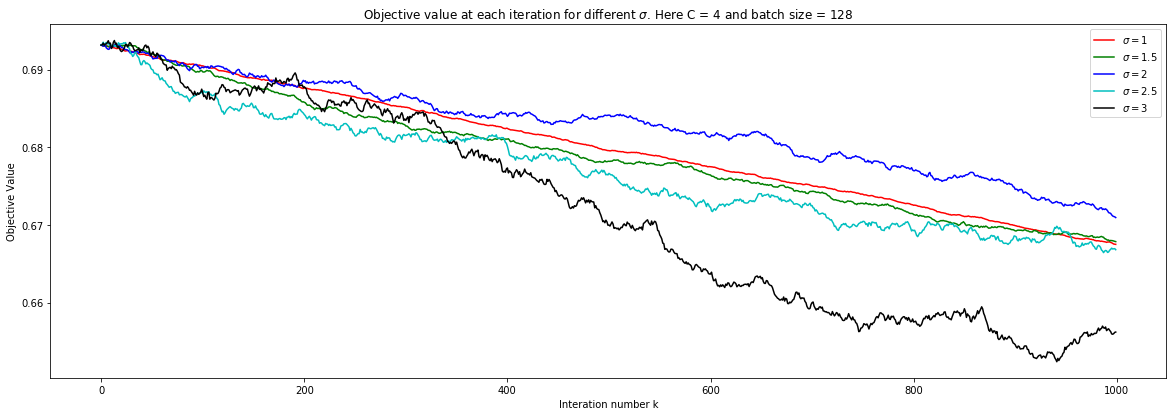

In [12]:
fig, ax = plt.subplots(figsize=(20, 6.5))
xplot = [*range(n_iter)]

for i in range(0,len(sigmas)):
    yplot = objs[i]
    ax.plot(xplot, yplot, col_sc[i] , label=r'$\sigma = $' + str(sigmas[i]))
ax.set_xlabel('Interation number k')
ax.set_ylabel('Objective Value')
ax.set_title(r'Objective value at each iteration for different $\sigma$. Here C = 4 and batch size = 128')
ax.legend(loc='best')



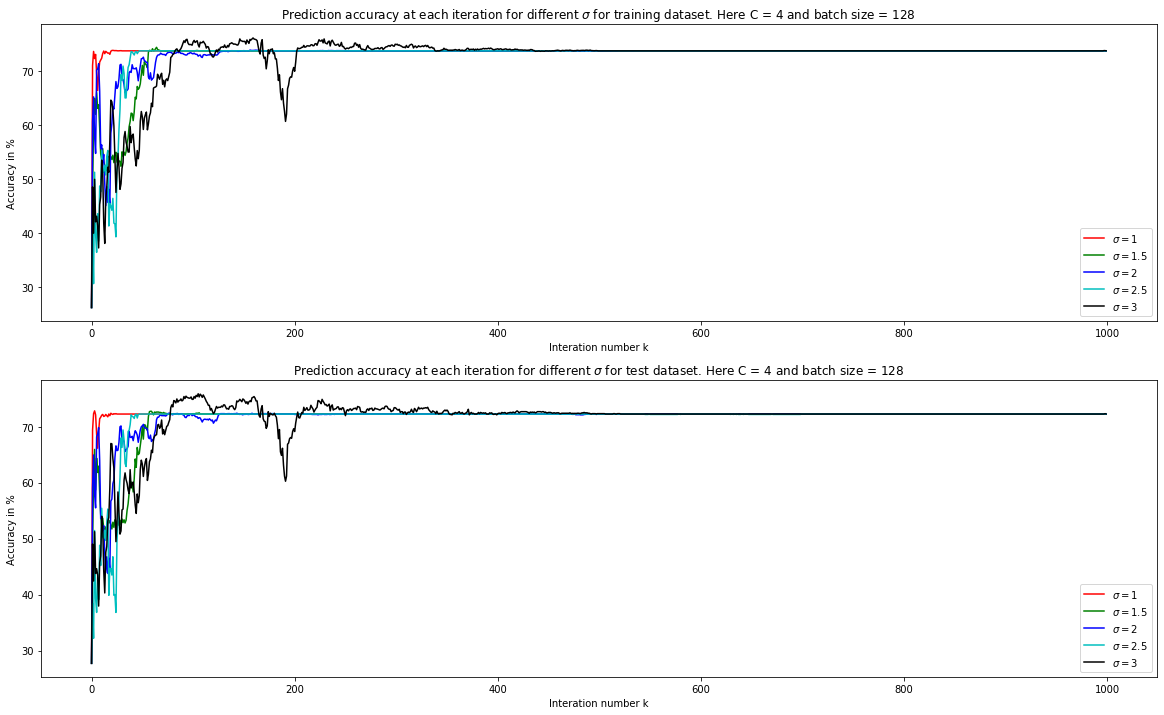

In [13]:
fig, ax = plt.subplots(2, figsize=(20, 12))
xplot = [*range(n_iter)]

for i in range(0,len(sigmas)):
    yplot = accs_train[i]
    ax[0].plot(xplot, yplot, col_sc[i] , label=r'$\sigma = $' + str(sigmas[i]))
ax[0].set_xlabel('Interation number k')
ax[0].set_ylabel('Accuracy in %')
ax[0].set_title(r'Prediction accuracy at each iteration for different $\sigma$ for training dataset. Here C = 4 and batch size = 128')
ax[0].legend(loc='best')

for i in range(0,len(sigmas)):
    yplot = accs_test[i]
    ax[1].plot(xplot, yplot, col_sc[i] , label=r'$\sigma = $' + str(sigmas[i]))
ax[1].set_xlabel('Interation number k')
ax[1].set_ylabel('Accuracy in %')
ax[1].set_title(r'Prediction accuracy at each iteration for different $\sigma$ for test dataset. Here C = 4 and batch size = 128')
ax[1].legend(loc='best')

### Q5. (10 pts) Show the effect of clipping threshold on the accuracy.
- Fix the noise level $\sigma$ to the value you found in Q4.
- Increase the value of $C$, say $[C, 2C, 4C, 5C]$. You can freely choose both the value of $C$ and the method with which you increase the value of $C$ to provide a best plot showing their relationship. Here, our goal is to show the impact of $C$ on the accuracy.

In [14]:
#---------------------------#
#    Your code goes here    #
#---------------------------#

C = 4 
sigma = 1
Cs = [C, 3*C, 5*C, 7*C, 9*C]
col_sc_train = ['r-','g-','b-','y-','k-']
col_sc_test = ['g*','b*','y*','k*','r*']
n_iter = 500
batch_size = 128

sols = []
objs = []
accs_train = []
accs_test = []


for i in Cs:
    sol, obj = dp_sgd(X_train, y_train, n_iter, i, sigma, batch_size)
    sols.append(sol)
    objs.append(obj)
    accs_train.append(compute_accuracy(X_train, y_train, sol))
    accs_test.append(compute_accuracy(X_test, y_test, sol))


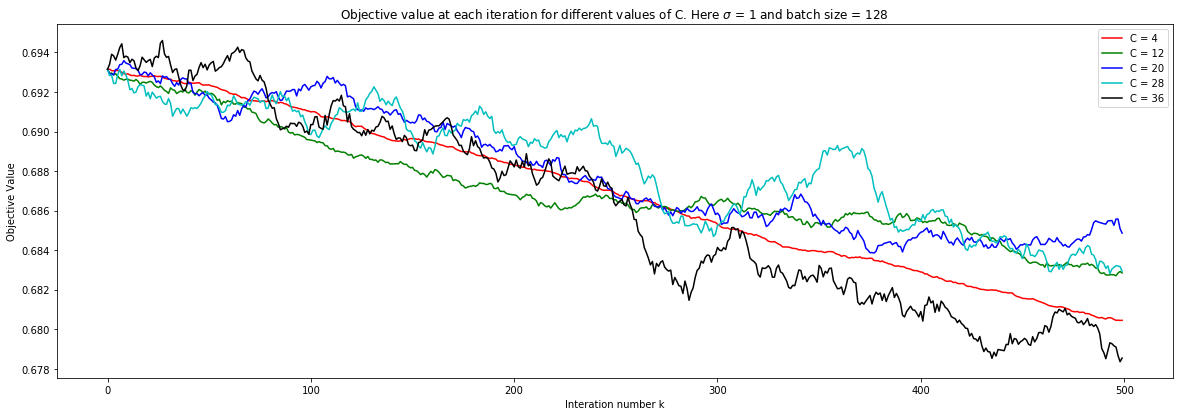

In [15]:
fig, ax = plt.subplots(figsize=(20, 6.5))
xplot = [*range(n_iter)]

for i in range(0,len(Cs)):
    yplot = objs[i]
    ax.plot(xplot, yplot, col_sc[i] , label='C = ' + str(Cs[i]))
ax.set_xlabel('Interation number k')
ax.set_ylabel('Objective Value')
ax.set_title(r'Objective value at each iteration for different values of C. Here $\sigma$ = 1 and batch size = 128')
ax.legend(loc='best')

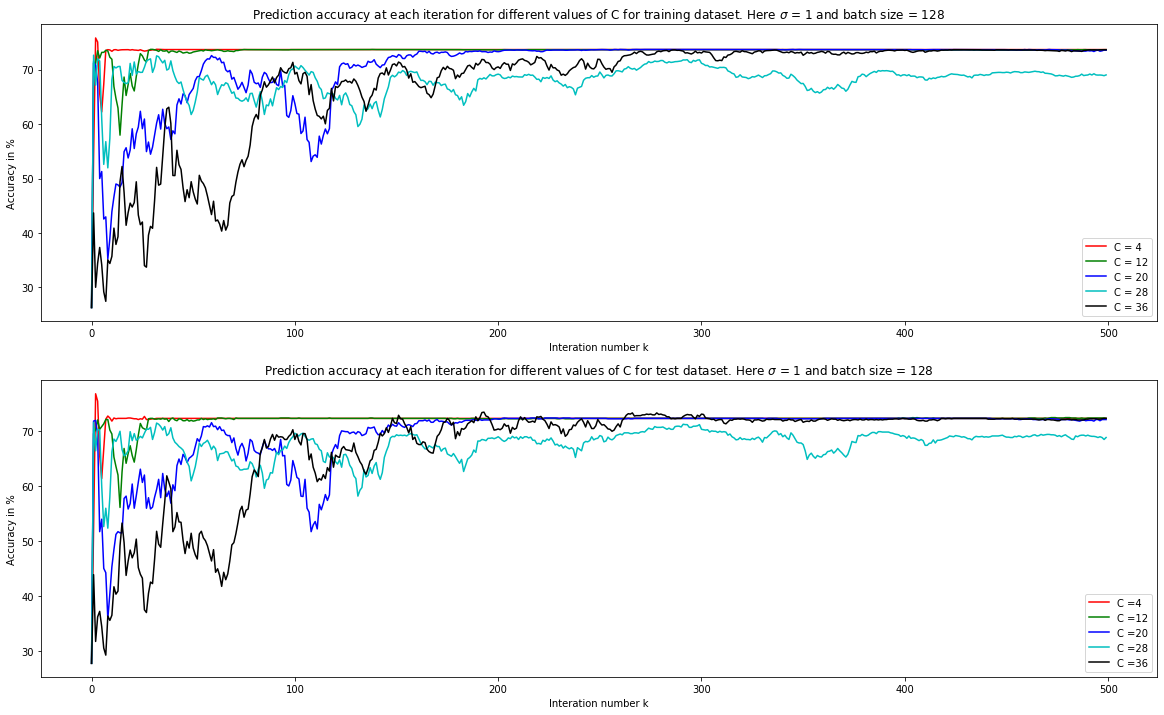

In [16]:
fig, ax = plt.subplots(2, figsize=(20, 12))
xplot = [*range(n_iter)]

for i in range(0,len(sigmas)):
    yplot = accs_train[i]
    ax[0].plot(xplot, yplot, col_sc[i] , label='C = ' + str(Cs[i]))
ax[0].set_xlabel('Interation number k')
ax[0].set_ylabel('Accuracy in %')
ax[0].set_title(r'Prediction accuracy at each iteration for different values of C for training dataset. Here $\sigma$ = 1 and batch size = 128')
ax[0].legend(loc='best')

for i in range(0,len(sigmas)):
    yplot = accs_test[i]
    ax[1].plot(xplot, yplot, col_sc[i] , label='C =' + str(Cs[i]))
ax[1].set_xlabel('Interation number k')
ax[1].set_ylabel('Accuracy in %')
ax[1].set_title(r'Prediction accuracy at each iteration for different values of C for test dataset. Here $\sigma$ = 1 and batch size = 128')
ax[1].legend(loc='best')

### Q6. (10 pts) Show the effect of batch size on the accuracy
- Fix the noise level $\sigma$, $C$, and max\_iter (again, the choice of best value is up to you)
- Try the following batch_size $|B| \in \{1, 32, 64, 128\}$
- Plot the change of accuracy agains the iterations .
- You will have 4 different lines in your plot, each of which corresponds to a distinct batch size.

In [17]:
#---------------------------#
#    Your code goes here    #
#---------------------------#

C = 4 
sigma = 2
col_sc_train = ['r-','g-','b-','y-','k-']
col_sc_test = ['g*','b*','y*','k*','r*']
n_iter = 400
batch_sizes = [16, 32, 64, 128, 256]

sols = []
objs = []
accs_train = []
accs_test = []


for i in batch_sizes:
    sol, obj = dp_sgd(X_train, y_train, n_iter, C, sigma, i)
    sols.append(sol)
    objs.append(obj)
    accs_train.append(compute_accuracy(X_train, y_train, sol))
    accs_test.append(compute_accuracy(X_test, y_test, sol))


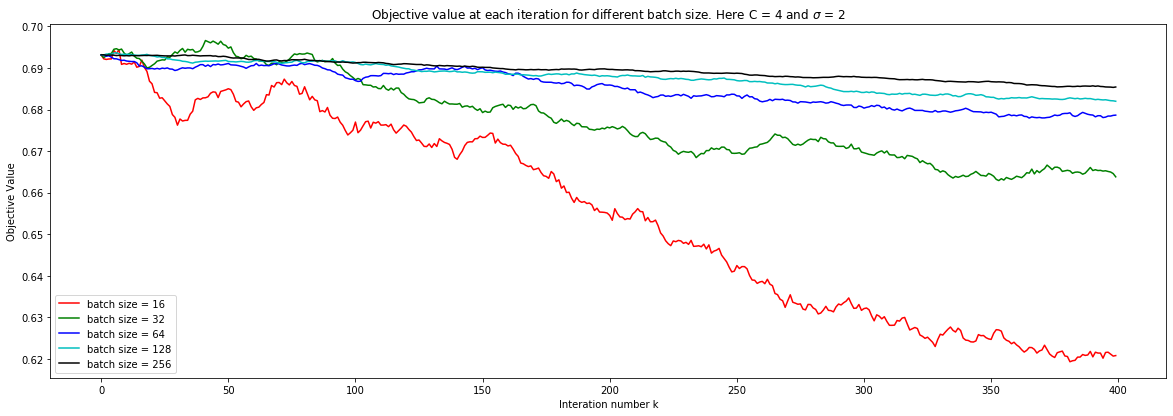

In [18]:
fig, ax = plt.subplots(figsize=(20, 6.5))
xplot = [*range(n_iter)]

for i in range(0,len(batch_sizes)):
    yplot = objs[i]
    ax.plot(xplot, yplot, col_sc[i] , label=r'batch size = ' + str(batch_sizes[i]))
ax.set_xlabel('Interation number k')
ax.set_ylabel('Objective Value')
ax.set_title(r'Objective value at each iteration for different batch size. Here C = 4 and $\sigma$ = 2')
ax.legend(loc='best')


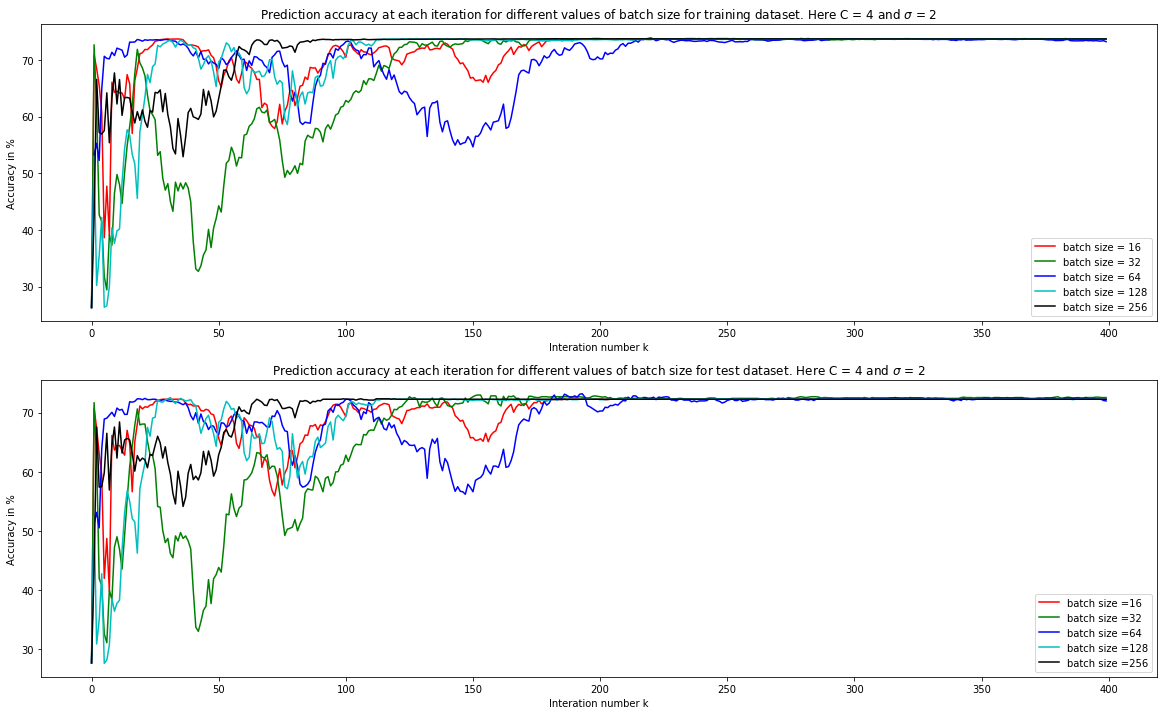

In [19]:
fig, ax = plt.subplots(2, figsize=(20, 12))
xplot = [*range(n_iter)]

for i in range(0,len(batch_sizes)):
    yplot = accs_train[i]
    ax[0].plot(xplot, yplot, col_sc[i] , label='batch size = ' + str(batch_sizes[i]))
ax[0].set_xlabel('Interation number k')
ax[0].set_ylabel('Accuracy in %')
ax[0].set_title(r'Prediction accuracy at each iteration for different values of batch size for training dataset. Here C = 4 and $\sigma$ = 2')
ax[0].legend(loc='best')

for i in range(0,len(batch_sizes)):
    yplot = accs_test[i]
    ax[1].plot(xplot, yplot, col_sc[i] , label='batch size =' + str(batch_sizes[i]))
ax[1].set_xlabel('Interation number k')
ax[1].set_ylabel('Accuracy in %')
ax[1].set_title(r'Prediction accuracy at each iteration for different values of batch size for test dataset. Here C = 4 and $\sigma$ = 2')
ax[1].legend(loc='best')